# Stark map for Rydberg helium

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm

In [2]:
# User variables
  # Whether to import the Stark interaction matrix, or calculate it
IMPORT_MAT_S = False
  # If calculating the Stark interaction matrix, whether to save it
SAVE_MAT_S = True
  # Whether to plot the Stark map
PLOT_STARK_MAP = True
  # If plot Stark map, whether to highlight specified lines
HIGHLIGHT_STARK_MAP_PLOT = False
  # If plot Stark map, whether to save out figure
SAVE_STARK_MAP_PLOT = True
  # Whether to save the Stark map data
SAVE_STARK_MAP_DATA = True

In [3]:
def getDataDir():
    # Create data directoy if it doesn't exist
    directory = os.path.join(".", "data")
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory
def getImagesDir():
    # Create data directoy if it doesn't exist
    directory = os.path.join(".", "images")
    if not os.path.exists(directory):
        os.makedirs(directory)
    return directory

In [4]:
# quantum numbers
nmin = 55
nmax = 56
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
# field-free Hamiltonian
H_0 = np.diag(En)
if (IMPORT_MAT_S):
    filename = "StarkIntMatrix_n_" + str(nmin) + "-" + str(nmax) + ".npy"
    directory = getDataDir()
    filein = os.path.join(directory, filename)
    try:
        mat_S = np.load(filein)
    except:
        raise
        
else:
    # find the off-diagonal terms of the Stark interaction matrix
    mat_S = stark_matrix(neff, L_vals, m_vals)
    if SAVE_MAT_S:
        # Create fileaname for Stark map
        filename = "StarkIntMatrix_n_" + str(nmin) + "-" + str(nmax)
        # Get data directoy, create it if it doesn't exist
        directory = getDataDir()
        # Save Stark interaction matrix to file
        fileout = os.path.join(directory, filename)
        np.save(fileout, mat_S)

calculate Stark terms: 100%|███████████████| 6161/6161 [02:54<00:00, 35.24it/s]


In [5]:
# specify the electric field
field = np.linspace(0.00, 4.0, 11) # V /cm
field_au = field * 100 * e * a_0 / En_h
# specify the magnetic field (in Telsa)
B_z = 0# 1.5776E-3
# (in atomic units)
B_z_au = B_z / (2.35*10**5)
# Zeeman interaction Hamiltonian
H_Z = np.diag(E_zeeman(m_vals, B_z_au))
# diagonalise for each field
map1 = stark_map(H_0, mat_S, field_au, H_Z=H_Z)

diagonalise Hamiltonian: 100%|█████████████████| 11/11 [23:49<00:00, 86.05s/it]


Plotting: 100%|███████████████████████████| 6161/6161 [00:44<00:00, 137.63it/s]


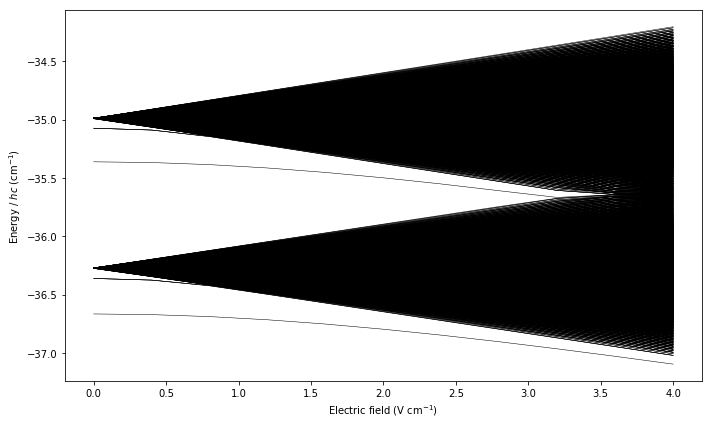

In [15]:
if(PLOT_STARK_MAP):
    # Stark map
    fig, ax = plt.subplots(figsize=(10, 6))

    #idx = np.intersect1d(np.where(n_vals == 55), np.where(m_vals <= 0))
    #for i in tqdm(idx, desc='Highlighting'):
    #    ax.plot(field, 0.01*map1[:, i] * En_h /(h * c), c='r', ls='-', lw=1.5)
        
    #idx = np.intersect1d(np.where(n_vals == 55), np.where(m_vals >= 0))
    #for i in tqdm(idx, desc='Highlighting'):
    #    ax.plot(field, 0.01*map1[:, i] * En_h /(h * c), c='b', ls='-', lw=1.5)
        
    for s0 in trange(np.shape(map1)[1], desc='Plotting'):
        ax.plot(field, 0.01*map1[:, s0] * En_h /(h * c), c='k', ls='-', marker='', lw=0.5)

    if(HIGHLIGHT_STARK_MAP_PLOT):
    # highlight (assuming states do not cross)
        idx = np.intersect1d(np.where(n_vals == 40), np.where(L_vals == 0))
        for i in tqdm(idx, desc='Highlighting'):
            ax.plot(field, 0.01*map1[:, i] * En_h /(h * c), c='r', ls='-', lw=1.5)

    # format
    #ax.set_ylim(-36.25, -36.22)
    #ax.set_xlim(0, 0.02)
    ax.set_xlabel('Electric field (V cm$^{-1}$)')
    ax.set_ylabel('Energy / $h c$ (cm$^{-1}$)')
    plt.tight_layout()
    # output
    if SAVE_STARK_MAP_PLOT==True:
        # Create fileaname for Stark map
        filename = "StarkMapPlot_n_" + str(nmin) + "-" + str(nmax) + \
        "_E_" + str(np.min(field)).replace('.', '-') + "_" + str(np.max(field)).replace('.', '-') + "_" + str(len(field)) + \
        "_B_" + str(B_z*1E3).replace('.', '-') + ".png"
        # Get images directoy, create it if it doesn't exist
        directory = getImagesDir()
        # Save Stark map to file
        fileout = os.path.join(directory, filename)
        plt.savefig(fileout)
    plt.show()
    plt.show()

# Write and Read files

In [9]:
if SAVE_STARK_MAP_DATA==True:
    # Create fileaname for Stark map
    filename = "StarkMapData_n_" + str(nmin) + "-" + str(nmax) + \
    "_E_" + str(np.min(field)).replace('.', '-') + "_" + str(np.max(field)).replace('.', '-') + "_" + str(len(field)) + \
    "_B_" + str(B_z*1E3).replace('.', '-')
    # Get data directoy, create it if it doesn't exist
    directory = getDataDir()
    # Save Stark map to file
    fileout = os.path.join(directory, filename)
    np.save(fileout, map1)